<a href="https://colab.research.google.com/github/ishankarve/Linear-Regression/blob/main/Multiple%20Linear%20Regression%20in%20Python/Assignment/Bike%20Sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Objective**
Build a multiple linear regression model for the prediction of demand for shared bikes. 

### **Problem Statement**

A US bike-sharing provider **BoomBikes** has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 

In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. 


### **Business Goal**

Find variables are significant in predicting the demand for shared bikes and how well those variables describe the bike demands
Based on various **meteorological surveys** and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors. 

Based on the goal mentioned above, model the demand for shared bikes with the available independent variables.

### **Data Caveats**

1.   In the dataset that some of the variables like 'weathersit' and 'season' have values as 1, 2, 3, 4 which have specific labels associated with them (as described in the data dictionary). These numeric values associated with the labels may indicate that there is some order to them - which is actually not the case. So, it is advisable to convert such feature values into categorical string values before proceeding with model building.

2.  The column 'yr' has two values 0 and 1 indicating the years 2018 and 2019 respectively. Since these bike-sharing systems are slowly gaining popularity, the demand for these bikes is increasing every year proving that the column 'yr' might be a good variable for prediction. So think twice before dropping it. 


### **Model Building**

In the dataset provided,there are three columns named 'casual', 'registered', and 'cnt'. The variable 'casual' indicates the number casual users who have made a rental. The variable 'registered' on the other hand shows the total number of registered users who have made a booking on a given day. Finally, the 'cnt' variable indicates the total number of bike rentals, including both casual and registered. ***The model should be built taking this 'cnt' as the target variable.***

### **Step 1: Import Libraries**


In [334]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [335]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

### **Step 2: Import Data**

In [336]:
#import data from gihub link
df_bikeshare=pd.read_csv("https://raw.githubusercontent.com/ishankarve/Linear-Regression/main/Multiple%20Linear%20Regression%20in%20Python/Assignment/day.csv")

In [337]:
df_bikeshare.head(730)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,27-12-2019,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796


# **Data Dictionary**
- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : whether day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : temperature in Celsius
- atemp: feeling temperature in Celsius
- hum: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

### **Step 3: Undertake sanity checks on data**

In [338]:
#get shape of the dataframe
df_bikeshare.shape

(730, 16)

In [339]:
#check column dtypes
df_bikeshare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [340]:
#get list of unique variables per column
print(df_bikeshare.nunique())

instant       730
dteday        730
season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           594
windspeed     649
casual        605
registered    678
cnt           695
dtype: int64


In [341]:
# get count of non-na values across all columns
df_bikeshare.apply(lambda x: x.count(), axis=0)

instant       730
dteday        730
season        730
yr            730
mnth          730
holiday       730
weekday       730
workingday    730
weathersit    730
temp          730
atemp         730
hum           730
windspeed     730
casual        730
registered    730
cnt           730
dtype: int64

In [342]:
# convert 'dteday' from 'object' to 'datetime'
df_bikeshare['dteday'] = pd.to_datetime(df_bikeshare['dteday'], format='%d-%m-%Y') #date is in 01-01-2018 format

In [343]:
#describe dataframe
df_bikeshare.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


### **Step 4: Cleaning & Binning Numerical Categorical Data**

In [344]:
#using 'OR' operation for holiday and working day to make holiday column redundant
df_bikeshare['workingday']=df_bikeshare['workingday'] + df_bikeshare['holiday']
#drop 'holiday' column
df_bikeshare.drop(['holiday'], axis = 1, inplace = True)


In [345]:
# binning windspeed data as per Beaufort Scale (https://www.rmets.org/metmatters/beaufort-scale)
# Note: Since temperature is in metric units (deg Celsius), it is assumed that windspeed is in Km/Hr

#bin_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
bin_labels = ['Calm','Light_air','Light_Breeze','Gentle_Breeze','Moderate_Breeze','Fresh_Breeze','Strong_Breeze','Moderate_Gale','Fresh_Gale','Strong_Gale','Whole_Gale','Storm','Hurricane']

bins = [0, 1, 5, 11, 19, 28, 38, 49, 61, 74, 88, 102, 117,300]
df_bikeshare['windspeed_binned'] = pd.cut(df_bikeshare['windspeed'], bins=bins, labels=bin_labels)

In [346]:
# binning temperature data as per comfort Scale (http://www.city-data.com/forum/weather/1620160-your-personal-temperature-colors-descriptors.html)
# data is binned as follows
# data is binned on a scale of 1 to 12
# 12- 45C & up: extremely hot 
# 11- 40 to 45C: very hot 
# 10- 35 to 40C: hot 
# 09- 30 to 35C: quite warm 
# 08 -20 to 30C: ideal 
# 07- 15 to 20C: lower than ideal 
# 06- 10 to 15C: cool 
# 05- 5 to 10C: quite cool 
# 04- 0 to 5C: cold 
# 03 -5 to 0C: very cold 
# 02- -10 to -5C: freezing 
# 01- -15 to -10C: frigid

#bin_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
bin_labels = ['Frigid','Freezing','Very_Cold','Cold','Quite_Cool','Cool','Lower_Ideal','Ideal','Quite_Warm','Hot','Very_Hot','Extremely_Hot']
bins = [-15,-10,-5,0,5,10,15,20,30,35,40,45,60]
df_bikeshare['temp_binned'] = pd.cut(df_bikeshare['temp'], bins=bins, labels=bin_labels)

In [347]:
#extracting day from date
df_bikeshare["day"]=df_bikeshare.dteday.dt.day

In [348]:
#binning months into quarters (1st,2nd,3rd,4th)
bin_labels = ['First', 'Second', 'Third', 'Fourth']
bins = [0,3,6,8,12]
df_bikeshare['quarter_binned'] = pd.cut(df_bikeshare['mnth'], bins=bins, labels=bin_labels)

In [349]:
#binning weekday  into labelled bins
bin_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday']
bins = [-1,0,1,2,3,4,5,6]
df_bikeshare['weekday_binned'] = pd.cut(df_bikeshare['weekday'], bins=bins, labels=bin_labels)

In [350]:
#binning humidity  into labelled bins
bin_labels = ['Too_Dry','Much_Dry', 'Dry', 'Near_Perfect', 'Perfect','About_Perfect','Sweaty', 'Too_Humid','Gross']
bins = [0, 10, 20, 30, 40, 60, 70, 80, 90, 100]
df_bikeshare['hum_binned'] = pd.cut(df_bikeshare['hum'], bins=bins, labels=bin_labels)

In [351]:
#binning months into labelled months)
bin_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
df_bikeshare['mnth_binned'] = pd.cut(df_bikeshare['mnth'], bins=bins, labels=bin_labels)

In [352]:
#binning months into labelled months)
bin_labels = ['Clear', 'Cloudy', 'Light_RainSnow', 'Heavy_RainSnow']
bins = [0, 1, 2, 3, 4]
df_bikeshare['weathersit_binned'] = pd.cut(df_bikeshare['weathersit'], bins=bins, labels=bin_labels)

In [353]:
#binning seasons into labelled variables
bin_labels = ['Spring', 'Summer', 'Autumn', 'Winter']
bins = [0, 1, 2, 3, 4]
df_bikeshare['season_binned'] = pd.cut(df_bikeshare['season'], bins=bins, labels=bin_labels)

### **Step 5: Prelimnary Visualisation**
Since all data is numeric, we can use plots to visualise data 

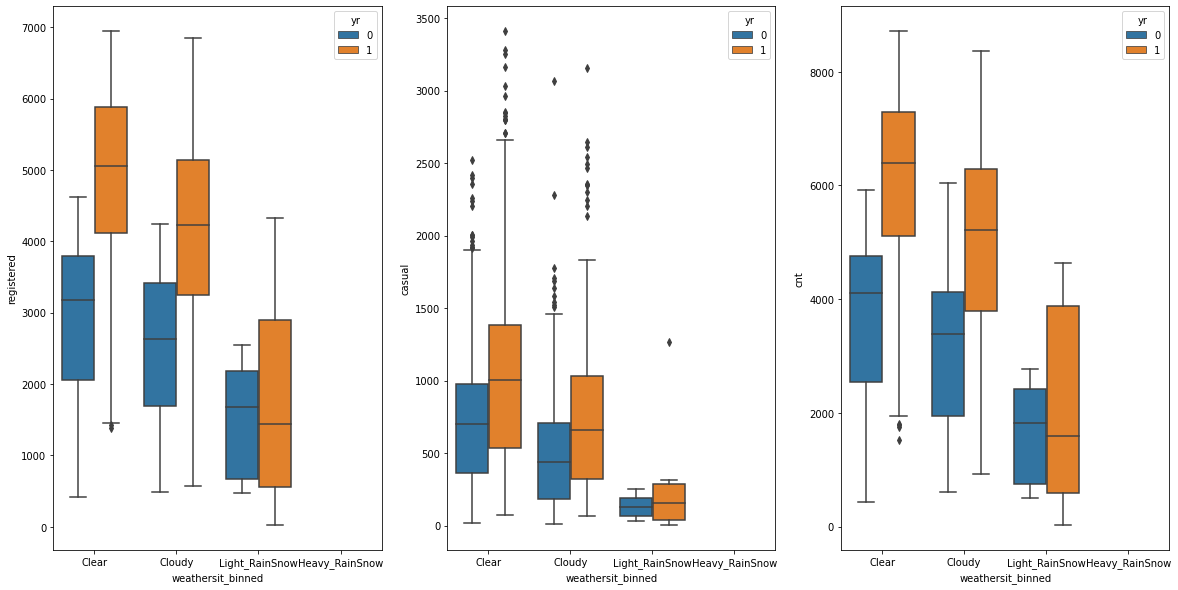

In [354]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'weathersit_binned', y = 'registered', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,2)
sns.boxplot(x = 'weathersit_binned', y = 'casual', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,3)
sns.boxplot(x = 'weathersit_binned', y = 'cnt', hue = 'yr', data = df_bikeshare)
plt.show()

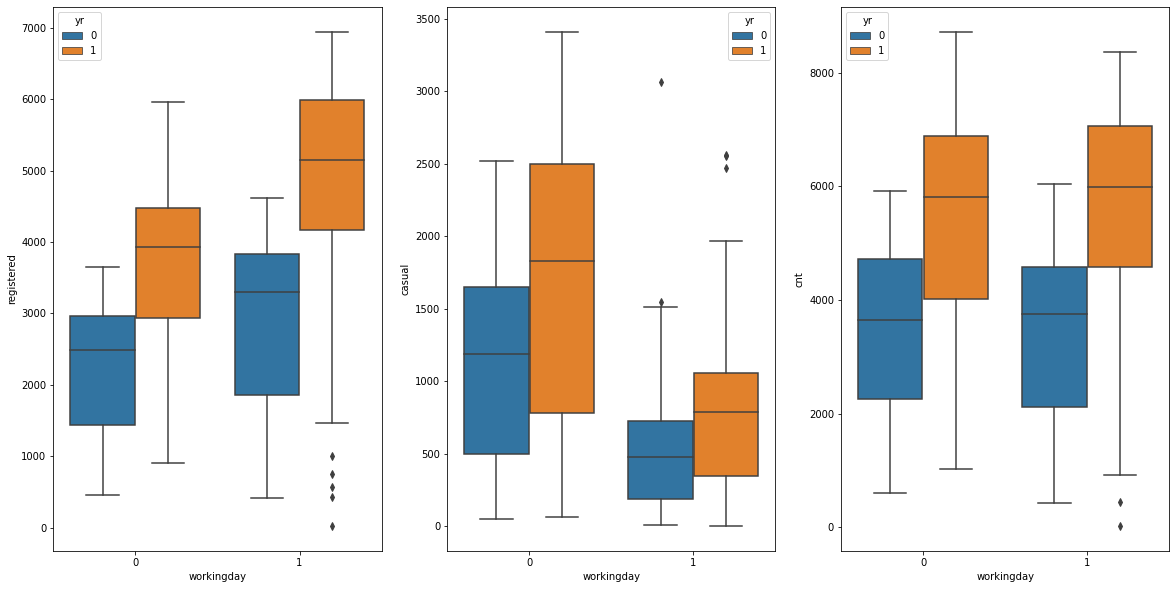

In [355]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'workingday', y = 'registered', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,2)
sns.boxplot(x = 'workingday', y = 'casual', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,3)
sns.boxplot(x = 'workingday', y = 'cnt', hue = 'yr', data = df_bikeshare)
plt.show()

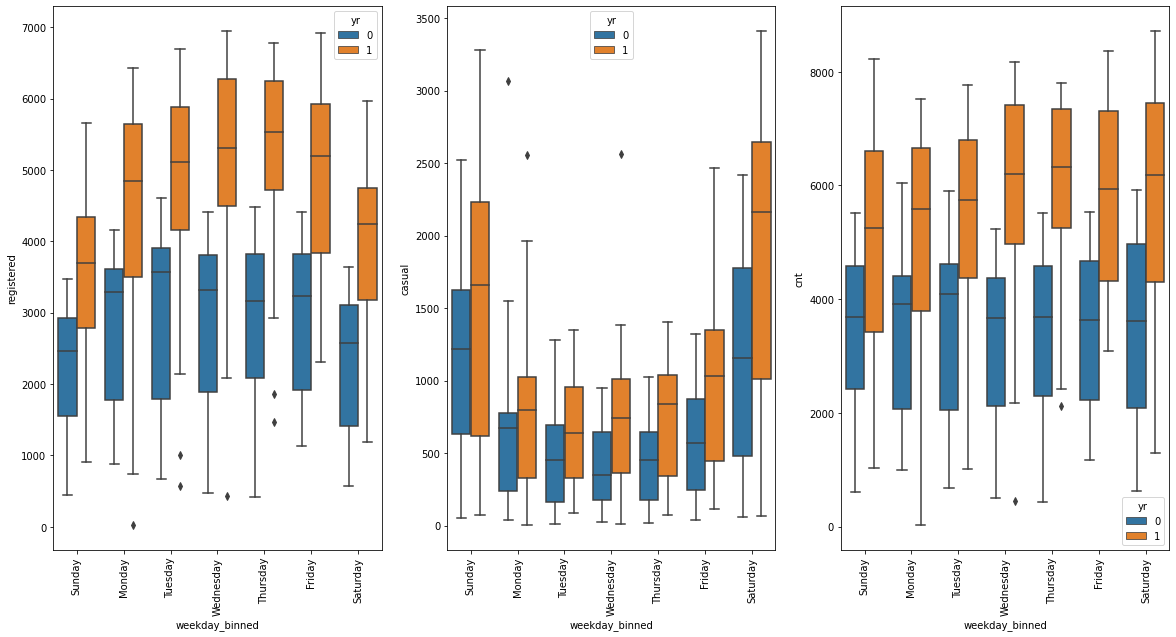

In [356]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'weekday_binned', y = 'registered', hue = 'yr', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,2)
sns.boxplot(x = 'weekday_binned', y = 'casual', hue = 'yr', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,3)
sns.boxplot(x = 'weekday_binned', y = 'cnt', hue = 'yr', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.show()

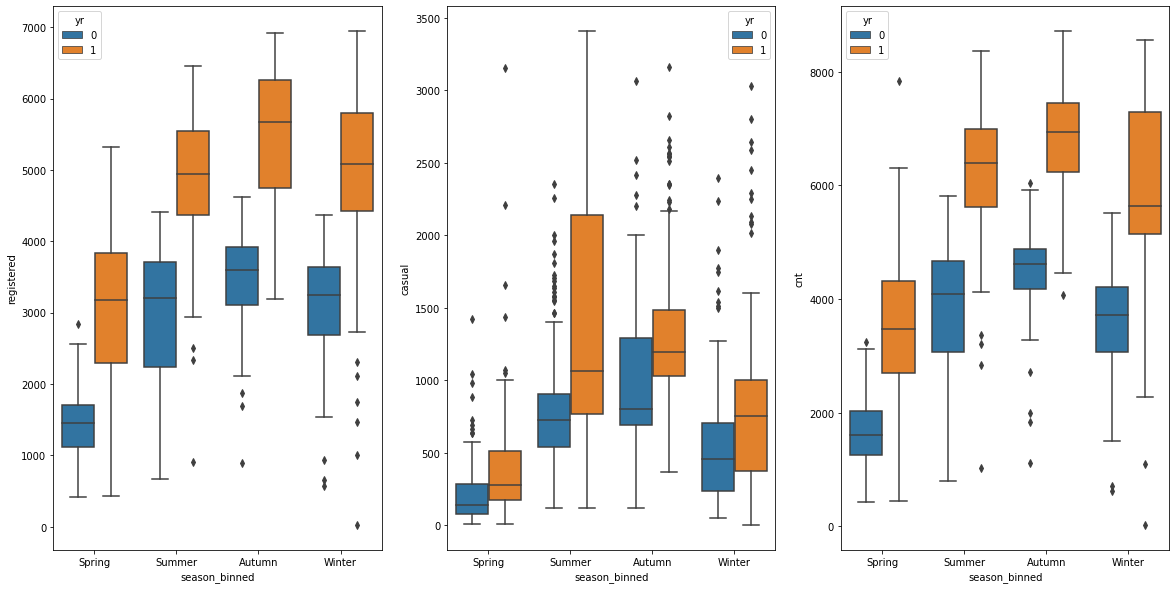

In [357]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'season_binned', y = 'registered', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,2)
sns.boxplot(x = 'season_binned', y = 'casual', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,3)
sns.boxplot(x = 'season_binned', y = 'cnt', hue = 'yr', data = df_bikeshare)
plt.show()

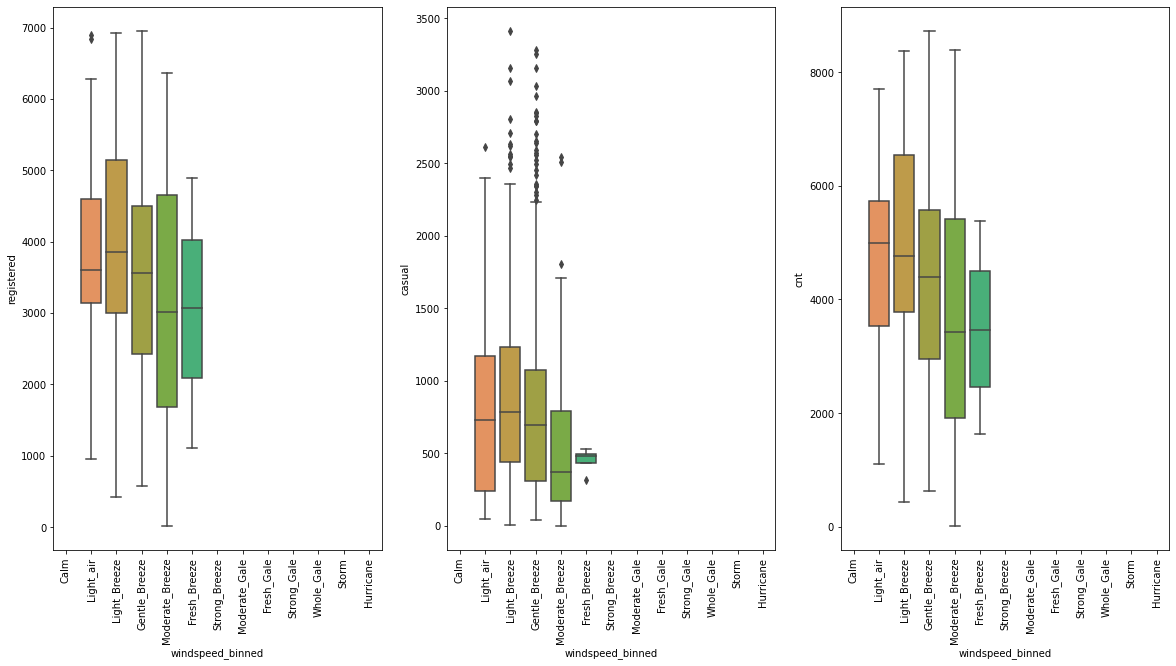

In [358]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'windspeed_binned', y = 'registered', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,2)
sns.boxplot(x = 'windspeed_binned', y = 'casual', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,3)
sns.boxplot(x = 'windspeed_binned', y = 'cnt', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.show()

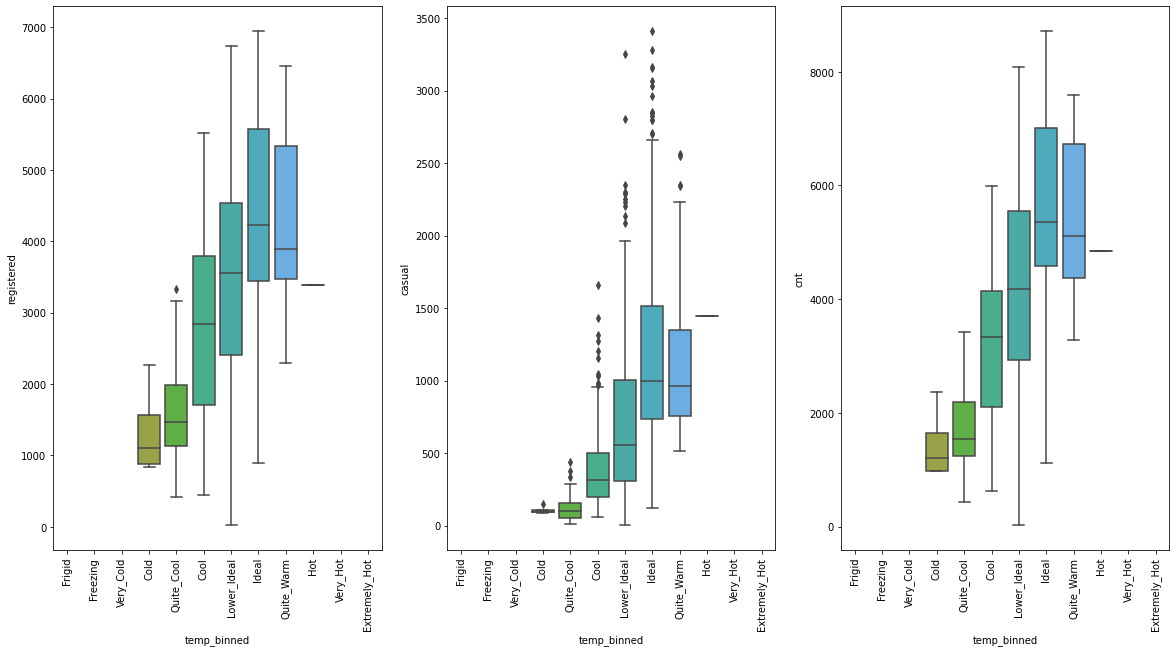

In [359]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'temp_binned', y = 'registered', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,2)
sns.boxplot(x = 'temp_binned', y = 'casual', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,3)
sns.boxplot(x = 'temp_binned', y = 'cnt', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.show()

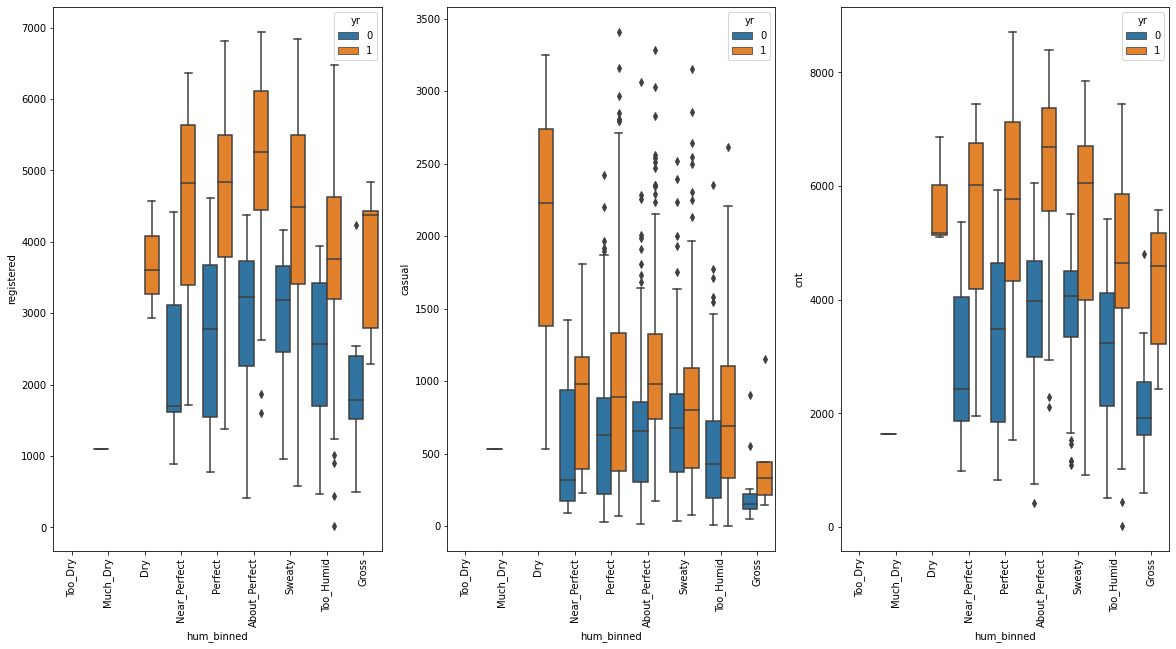

In [360]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'hum_binned', y = 'registered', hue = 'yr', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,2)
sns.boxplot(x = 'hum_binned', y = 'casual', hue = 'yr', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.subplot(1,3,3)
sns.boxplot(x = 'hum_binned', y = 'cnt', hue = 'yr', data = df_bikeshare)
plt.xticks(rotation='vertical')
plt.show()

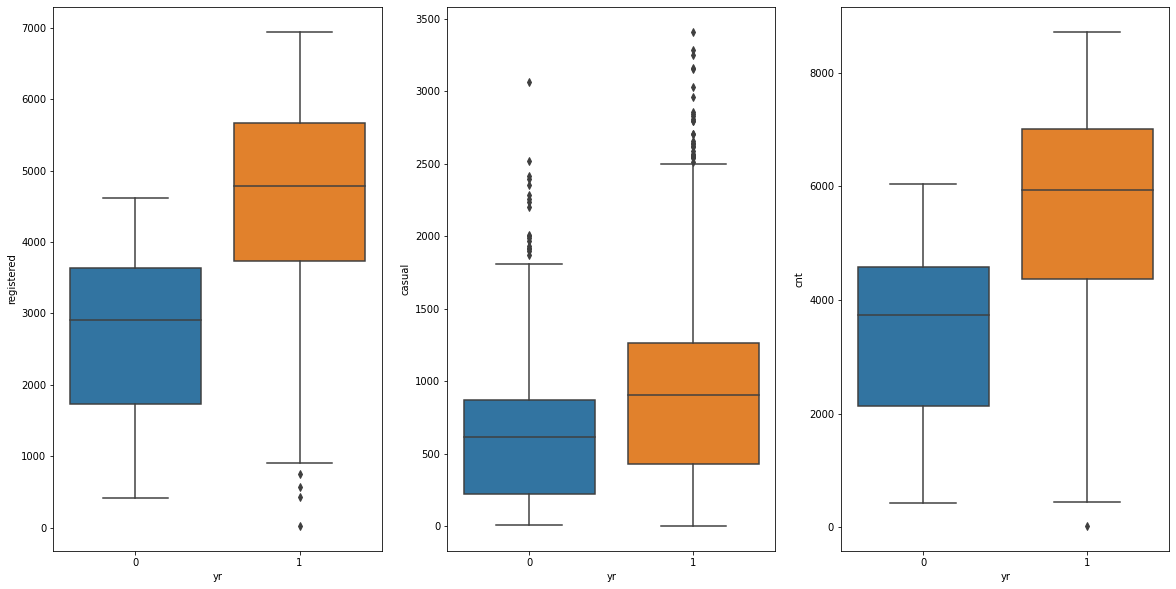

In [361]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'yr', y = 'registered', data = df_bikeshare)
plt.subplot(1,3,2)
sns.boxplot(x = 'yr', y = 'casual', data = df_bikeshare)
plt.subplot(1,3,3)
sns.boxplot(x = 'yr', y = 'cnt', data = df_bikeshare)
plt.show()

In [362]:
#plot chart per day to find specific days where surge can be expected

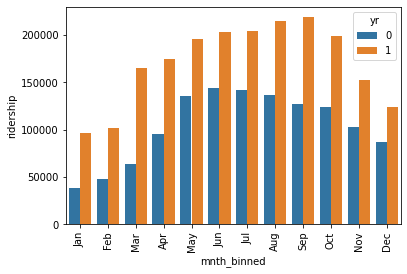

In [363]:
#plot variation across months
# perform groupby
df = df_bikeshare.groupby(['mnth_binned','yr']).agg(ridership=("cnt", 'sum'))
df = df.reset_index()
  
# plot barplot
sns.barplot(x="mnth_binned",y="ridership",hue="yr",data=df)
plt.xticks(rotation='vertical')
plt.show()

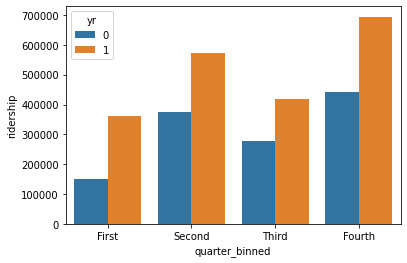

In [364]:
#plot variation across quarters
# perform groupby
df = df_bikeshare.groupby(['quarter_binned','yr']).agg(ridership=("cnt", 'sum'))
df = df.reset_index()
  
# plot barplot
sns.barplot(x="quarter_binned",y="ridership",hue='yr',data=df)

plt.show()

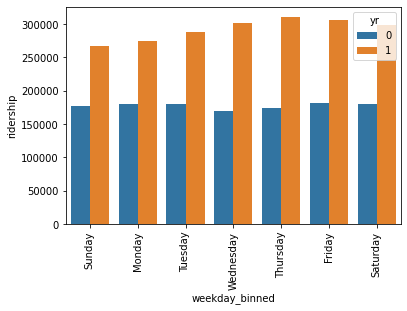

In [365]:
#plot variation across weekdays
# perform groupby
df = df_bikeshare.groupby(['weekday_binned','yr']).agg(ridership=("cnt", 'sum'))
df = df.reset_index()
  
# plot barplot
sns.barplot(x="weekday_binned",y="ridership",hue='yr',data=df)
plt.xticks(rotation='vertical')
plt.show()

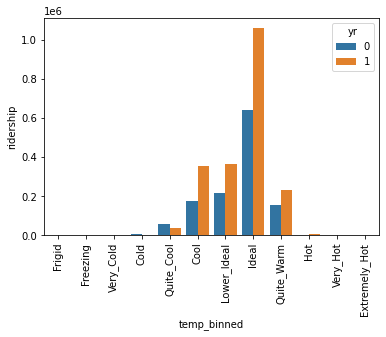

In [366]:
#plot variation across temperature conditions
# perform groupby
df = df_bikeshare.groupby(['temp_binned','yr']).agg(ridership=("cnt", 'sum'))
df = df.reset_index()
  
# plot barplot
sns.barplot(x="temp_binned",y="ridership",hue='yr',data=df)
plt.xticks(rotation='vertical')
plt.show()

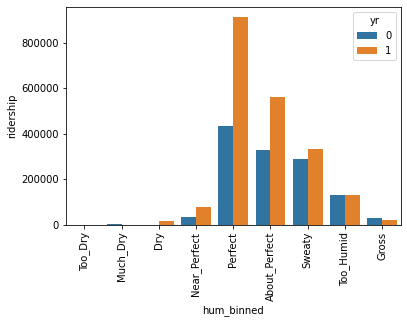

In [367]:
#plot variation across humidity conditions
# perform groupby
df = df_bikeshare.groupby(['hum_binned','yr']).agg(ridership=("cnt", 'sum'))
df = df.reset_index()
  
# plot barplot
sns.barplot(x="hum_binned",y="ridership",hue='yr',data=df)
plt.xticks(rotation='vertical')
plt.show()

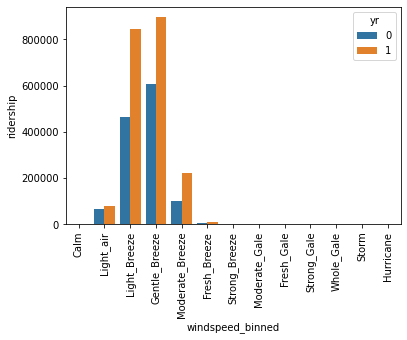

In [368]:
#plot variation across wind conditions
# perform groupby
df = df_bikeshare.groupby(['windspeed_binned','yr']).agg(ridership=("cnt", 'sum'))
df = df.reset_index()
  
# plot barplot
sns.barplot(x="windspeed_binned",y="ridership",hue='yr',data=df)
plt.xticks(rotation='vertical')
plt.show()

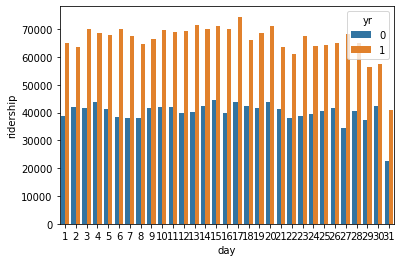

In [369]:
#plot variation across day
# perform groupby
df = df_bikeshare.groupby(['day','yr']).agg(ridership=("cnt", 'sum'))
df = df.reset_index()
  
#plot barplot
sns.barplot(x="day",y="ridership",hue='yr',data=df)

plt.show()

In [370]:
print(df_bikeshare.nunique())

instant              730
dteday               730
season                 4
yr                     2
mnth                  12
weekday                7
workingday             2
weathersit             3
temp                 498
atemp                689
hum                  594
windspeed            649
casual               605
registered           678
cnt                  695
windspeed_binned       5
temp_binned            7
day                   31
quarter_binned         4
weekday_binned         7
hum_binned             8
mnth_binned           12
weathersit_binned      3
season_binned          4
dtype: int64


In [371]:
df_bikeshare.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'windspeed_binned', 'temp_binned', 'day',
       'quarter_binned', 'weekday_binned', 'hum_binned', 'mnth_binned',
       'weathersit_binned', 'season_binned'],
      dtype='object')

### **Step 6: Creating Dummy Variables**

In [372]:
#create dummy variables for binned categorial variables
windspeed_dummy = pd.get_dummies(df_bikeshare['windspeed_binned'],drop_first=True)
temp_dummy = pd.get_dummies(df_bikeshare['temp_binned'],drop_first=True)
quarter_dummy = pd.get_dummies(df_bikeshare['quarter_binned'],drop_first=True)
weathersit_dummy = pd.get_dummies(df_bikeshare['weathersit_binned'],drop_first=True)
weekday_dummy = pd.get_dummies(df_bikeshare['weekday_binned'],drop_first=True)
hum_dummy = pd.get_dummies(df_bikeshare['hum_binned'],drop_first=True)
mnth_dummy = pd.get_dummies(df_bikeshare['mnth_binned'],drop_first=True)
season_dummy = pd.get_dummies(df_bikeshare['season_binned'],drop_first=True)





In [373]:
#drop corresponding categorical variables
#Reference: https://stackoverflow.com/questions/19071199/drop-columns-whose-name-contains-a-specific-string-from-pandas-dataframe
df_bikeshare.drop(list(df_bikeshare.filter(regex = 'binned')), axis = 1, inplace = True)

In [374]:
#check dataframe for columns deletion
df_bikeshare.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'day'],
      dtype='object')

In [375]:
#check variables
print(windspeed_dummy.nunique())
print(temp_dummy.nunique())
print(quarter_dummy.nunique())
print(weathersit_dummy.nunique())
print(weekday_dummy.nunique())
print(hum_dummy.nunique())
print(mnth_dummy.nunique())
print(season_dummy.nunique())

Light_air          2
Light_Breeze       2
Gentle_Breeze      2
Moderate_Breeze    2
Fresh_Breeze       2
Strong_Breeze      1
Moderate_Gale      1
Fresh_Gale         1
Strong_Gale        1
Whole_Gale         1
Storm              1
Hurricane          1
dtype: int64
Freezing         1
Very_Cold        1
Cold             2
Quite_Cool       2
Cool             2
Lower_Ideal      2
Ideal            2
Quite_Warm       2
Hot              2
Very_Hot         1
Extremely_Hot    1
dtype: int64
Second    2
Third     2
Fourth    2
dtype: int64
Cloudy            2
Light_RainSnow    2
Heavy_RainSnow    1
dtype: int64
Monday       2
Tuesday      2
Wednesday    2
Thursday     2
Friday       2
Saturday     2
dtype: int64
Much_Dry         2
Dry              2
Near_Perfect     2
Perfect          2
About_Perfect    2
Sweaty           2
Too_Humid        2
Gross            2
dtype: int64
Feb    2
Mar    2
Apr    2
May    2
Jun    2
Jul    2
Aug    2
Sep    2
Oct    2
Nov    2
Dec    2
dtype: int64
Summer    2

In [376]:
#concat dummy variable dataframe to the main dataframe
df_bikeshare = pd.concat([df_bikeshare, windspeed_dummy], axis = 1)
df_bikeshare = pd.concat([df_bikeshare, temp_dummy], axis = 1)
#df_bikeshare = pd.concat([df_bikeshare, weathersit_dummy], axis = 1)
df_bikeshare = pd.concat([df_bikeshare, weekday_dummy], axis = 1)                         
df_bikeshare = pd.concat([df_bikeshare, hum_dummy], axis = 1)
#df_bikeshare = pd.concat([df_bikeshare, mnth_dummy], axis = 1)
#df_bikeshare = pd.concat([df_bikeshare, quarter_dummy], axis = 1)
#df_bikeshare = pd.concat([df_bikeshare, season_dummy], axis = 1)

In [377]:
#check dataframe for columns concatenation
df_bikeshare.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'day', 'Light_air', 'Light_Breeze',
       'Gentle_Breeze', 'Moderate_Breeze', 'Fresh_Breeze', 'Strong_Breeze',
       'Moderate_Gale', 'Fresh_Gale', 'Strong_Gale', 'Whole_Gale', 'Storm',
       'Hurricane', 'Freezing', 'Very_Cold', 'Cold', 'Quite_Cool', 'Cool',
       'Lower_Ideal', 'Ideal', 'Quite_Warm', 'Hot', 'Very_Hot',
       'Extremely_Hot', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Much_Dry', 'Dry', 'Near_Perfect', 'Perfect',
       'About_Perfect', 'Sweaty', 'Too_Humid', 'Gross'],
      dtype='object')

In [378]:
#drop columns where there is no variable diversity
for col in df_bikeshare.columns:
    if len(df_bikeshare[col].unique()) == 1:
        df_bikeshare.drop(col,inplace=True,axis=1)
#windspeed_dummy.drop(['Calm', 'Strong_Breeze', 'Moderate_Gale','Fresh_Gale','Strong_Gale','Whole_Gale','Storm','Hurricane'], axis=1, inplace=True)
#temp_dummy.drop(['Frigid','Freezing','Very_Cold','Very_Hot','Extremely_Hot'], axis=1, inplace=True)
#quarter_dummy.drop(['First'], axis=1, inplace=True) #variable can be described by balance three

In [379]:
#check master dataframe
print(df_bikeshare.nunique())


instant            730
dteday             730
season               4
yr                   2
mnth                12
weekday              7
workingday           2
weathersit           3
temp               498
atemp              689
hum                594
windspeed          649
casual             605
registered         678
cnt                695
day                 31
Light_air            2
Light_Breeze         2
Gentle_Breeze        2
Moderate_Breeze      2
Fresh_Breeze         2
Cold                 2
Quite_Cool           2
Cool                 2
Lower_Ideal          2
Ideal                2
Quite_Warm           2
Hot                  2
Monday               2
Tuesday              2
Wednesday            2
Thursday             2
Friday               2
Saturday             2
Much_Dry             2
Dry                  2
Near_Perfect         2
Perfect              2
About_Perfect        2
Sweaty               2
Too_Humid            2
Gross                2
dtype: int64


In [380]:
df_bikeshare.columns.tolist()

['instant',
 'dteday',
 'season',
 'yr',
 'mnth',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt',
 'day',
 'Light_air',
 'Light_Breeze',
 'Gentle_Breeze',
 'Moderate_Breeze',
 'Fresh_Breeze',
 'Cold',
 'Quite_Cool',
 'Cool',
 'Lower_Ideal',
 'Ideal',
 'Quite_Warm',
 'Hot',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Much_Dry',
 'Dry',
 'Near_Perfect',
 'Perfect',
 'About_Perfect',
 'Sweaty',
 'Too_Humid',
 'Gross']

In [381]:
#drop original categorical and redundant columns
df_bikeshare.drop(['instant',
 'dteday',
 'season',
 'mnth',
 'weekday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered'], axis = 1, inplace = True)
df_bikeshare.head(10)

,yr,workingday,cnt,day,Light_air,Light_Breeze,Gentle_Breeze,Moderate_Breeze,Fresh_Breeze,Cold,...,Friday,Saturday,Much_Dry,Dry,Near_Perfect,Perfect,About_Perfect,Sweaty,Too_Humid,Gross
0,0,0,985,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,801,2,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,1349,3,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,1562,4,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,1,1600,5,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,0,1,1606,6,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,0,1,1510,7,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
7,0,0,959,8,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
8,0,0,822,9,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
9,0,1,1321,10,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### **Step 7: Splitting and Scaling data**

In [382]:
#check dataframe
print(df_bikeshare.nunique())

yr                   2
workingday           2
cnt                695
day                 31
Light_air            2
Light_Breeze         2
Gentle_Breeze        2
Moderate_Breeze      2
Fresh_Breeze         2
Cold                 2
Quite_Cool           2
Cool                 2
Lower_Ideal          2
Ideal                2
Quite_Warm           2
Hot                  2
Monday               2
Tuesday              2
Wednesday            2
Thursday             2
Friday               2
Saturday             2
Much_Dry             2
Dry                  2
Near_Perfect         2
Perfect              2
About_Perfect        2
Sweaty               2
Too_Humid            2
Gross                2
dtype: int64


In [383]:
## before we split the data we are going to copy the data in three dataframes for 3 modelling strategies

#copy dataframe
s1_df=df_bikeshare.copy()
# s2_df=df_bikeshare.copy()
# s3_df=df_bikeshare.copy()

In [384]:
#splitting data
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(564)
s1_train, s1_test = train_test_split(s1_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [385]:
s1_train.columns

Index(['yr', 'workingday', 'cnt', 'day', 'Light_air', 'Light_Breeze',
       'Gentle_Breeze', 'Moderate_Breeze', 'Fresh_Breeze', 'Cold',
       'Quite_Cool', 'Cool', 'Lower_Ideal', 'Ideal', 'Quite_Warm', 'Hot',
       'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Much_Dry', 'Dry', 'Near_Perfect', 'Perfect', 'About_Perfect', 'Sweaty',
       'Too_Humid', 'Gross'],
      dtype='object')

In [386]:
#set up scaler
scaler = MinMaxScaler()
# Apply scaler() to all the columns except  'cnt' variable
num_vars=s1_train.columns.tolist()
num_vars.remove('cnt')
s1_train[num_vars] = scaler.fit_transform(s1_train[num_vars])

In [387]:
s1_train.head(10)

,yr,workingday,cnt,day,Light_air,Light_Breeze,Gentle_Breeze,Moderate_Breeze,Fresh_Breeze,Cold,...,Friday,Saturday,Much_Dry,Dry,Near_Perfect,Perfect,About_Perfect,Sweaty,Too_Humid,Gross
653,1.0,1.0,7534,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
576,1.0,1.0,7216,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
426,1.0,0.0,4066,0.066667,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
728,1.0,0.0,1796,0.966667,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
482,1.0,0.0,4220,0.900000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
111,0.0,1.0,1683,0.700000,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
580,1.0,0.0,6824,0.100000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
500,1.0,1.0,7424,0.500000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
479,1.0,1.0,6196,0.800000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
472,1.0,1.0,4367,0.566667,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


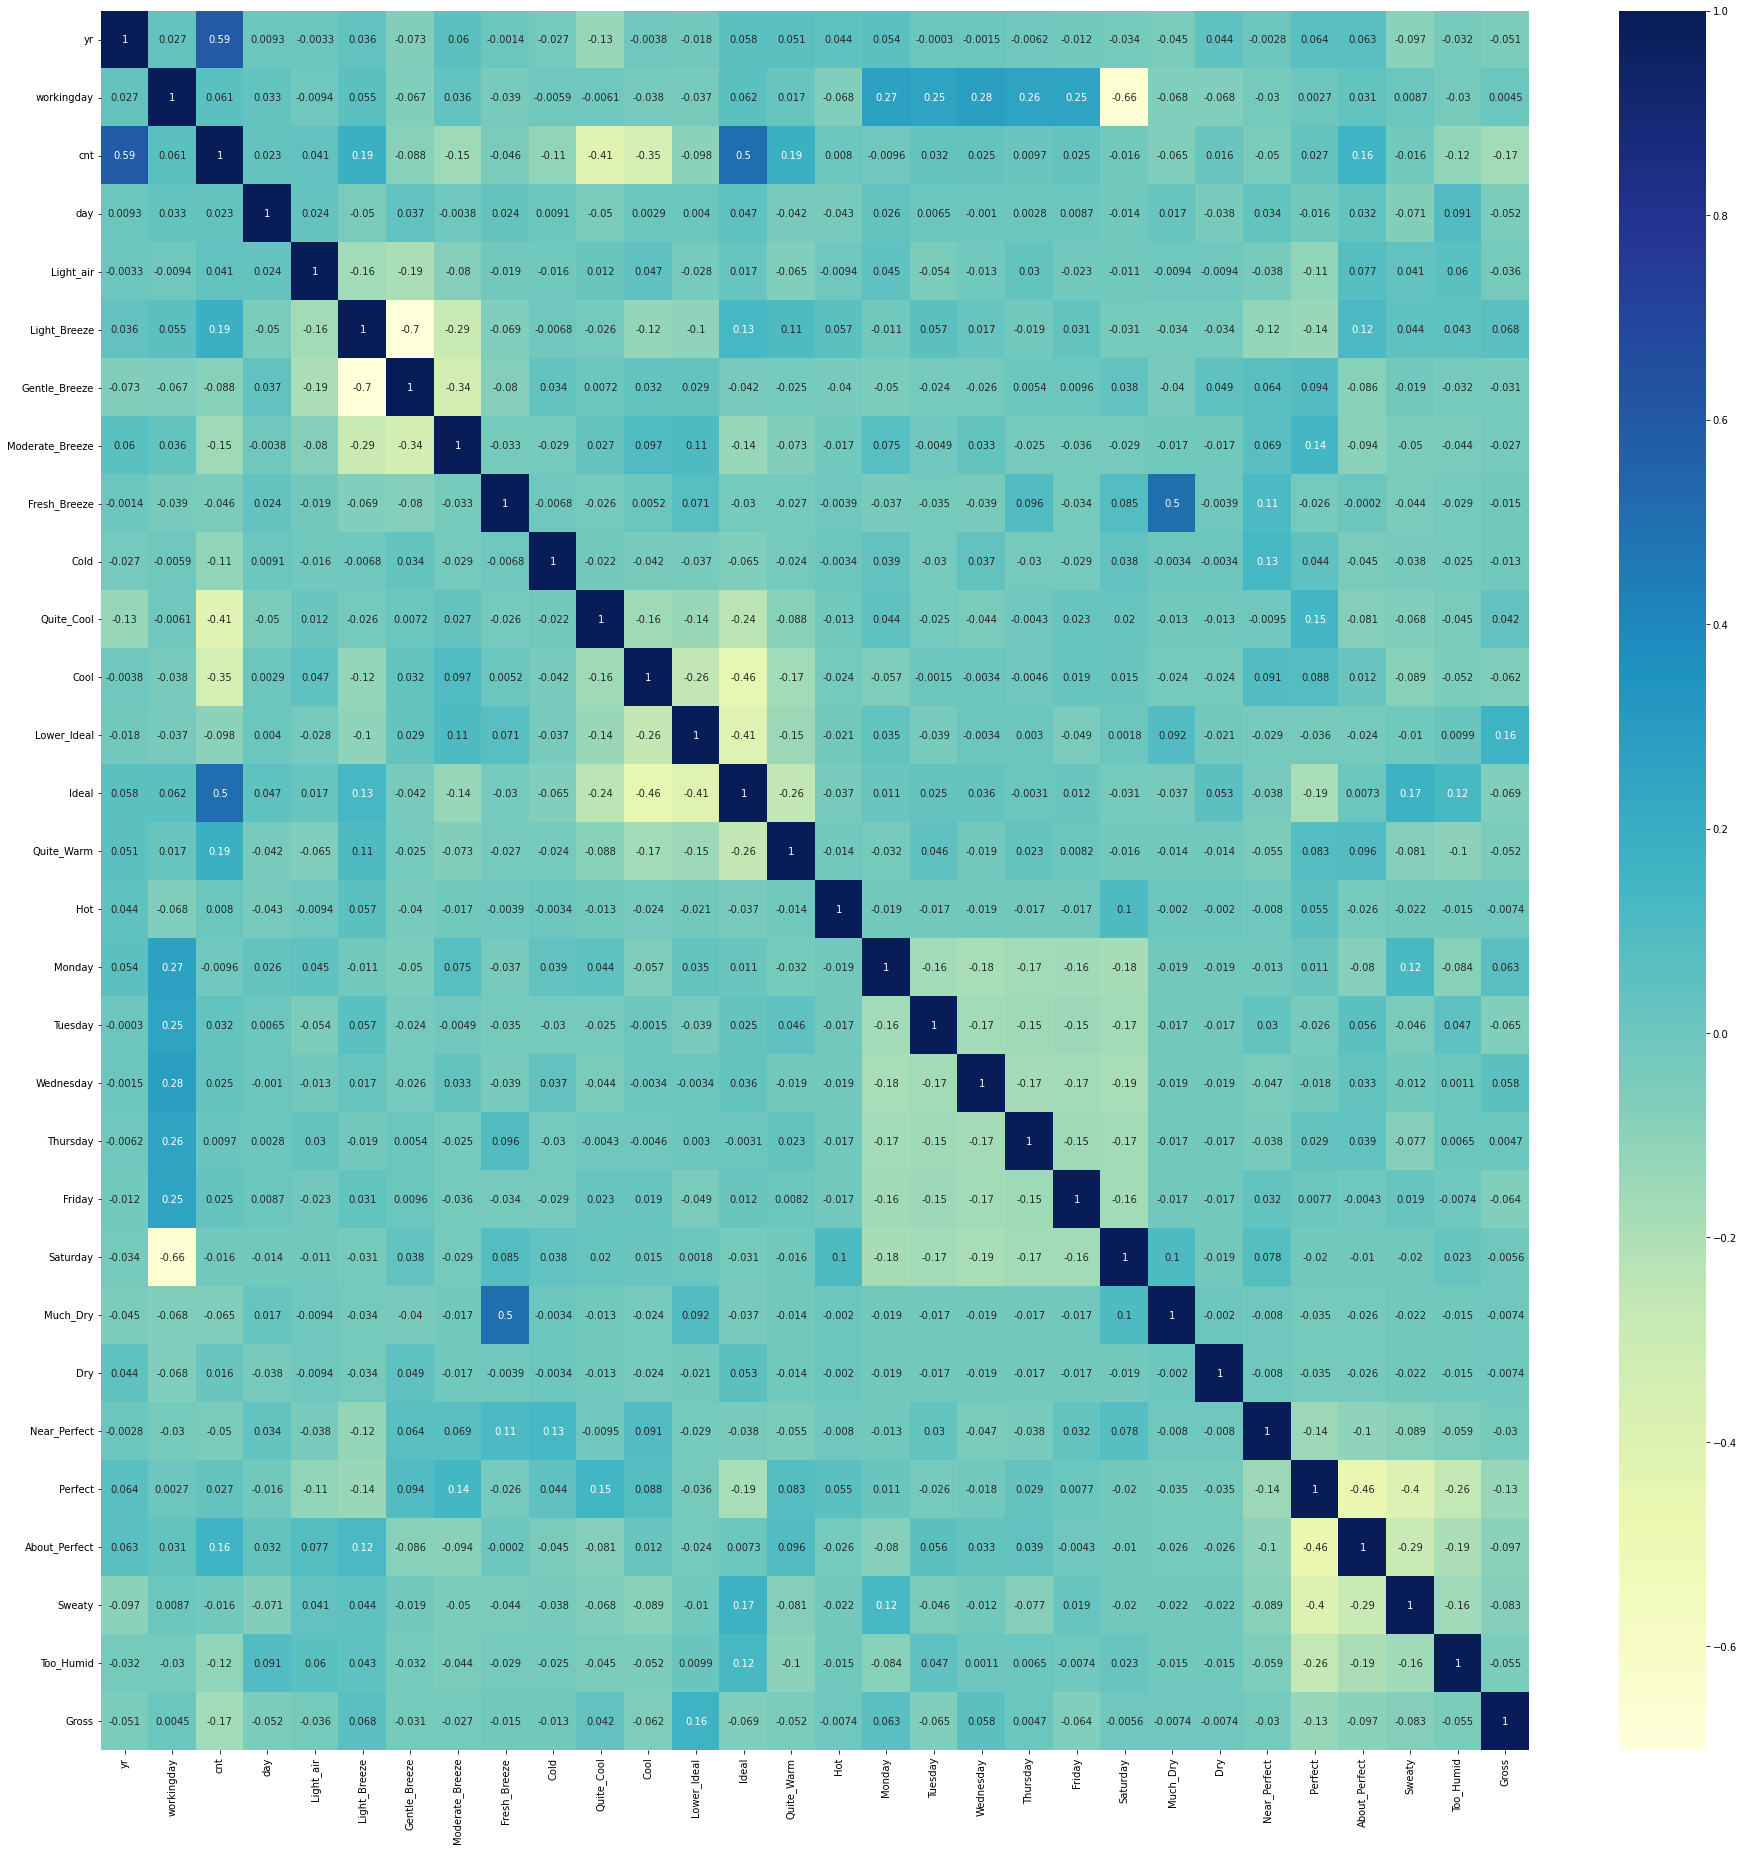

In [388]:
# Checking the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (32, 32))
sns.heatmap(s1_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [389]:
#check column dtypes
s1_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 653 to 79
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yr               510 non-null    float64
 1   workingday       510 non-null    float64
 2   cnt              510 non-null    int64  
 3   day              510 non-null    float64
 4   Light_air        510 non-null    float64
 5   Light_Breeze     510 non-null    float64
 6   Gentle_Breeze    510 non-null    float64
 7   Moderate_Breeze  510 non-null    float64
 8   Fresh_Breeze     510 non-null    float64
 9   Cold             510 non-null    float64
 10  Quite_Cool       510 non-null    float64
 11  Cool             510 non-null    float64
 12  Lower_Ideal      510 non-null    float64
 13  Ideal            510 non-null    float64
 14  Quite_Warm       510 non-null    float64
 15  Hot              510 non-null    float64
 16  Monday           510 non-null    float64
 17  Tuesday        

###### **Checking for Multicollinearity using recursive method**

#### Splitting into sub set

In [390]:
y_train = s1_train.pop('cnt')
X_train = s1_train

### Step 8: Building a linear regression model

**Undertake Recursive VIF analysis** 

In [391]:
##reference: https://www.geeksforgeeks.org/multicollinearity-in-data/
#create a test dataframe
vif_df=s1_train.copy()
#shuffle the column ordering
#import random
#column_shuffle=vif_df.columns.tolist() #convert pandas index to list
#random.shuffle(column_shuffle) #shuffle list
#shuffle dataframe columns
#set_column_sequence(vif_df, column_shuffle, front=True) #not required

Y = y_train
iv = vif_df.columns
X = vif_df[iv]
#reference: https://github.com/statsmodels/statsmodels/issues/2376
#add constant prior calculating VIF
X = sm.add_constant(X)
# calculate the variance inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
 # compare with each column
[vif(vif_df[iv].values, index) for index in range(len(iv))]
# compare with each columns
for i in range(len(iv)):
    vif_list = [vif(vif_df[iv].values, index) for index in range(len(iv))]
    maxvif = max(vif_list)

    drop_index = vif_list.index(maxvif)
    print("Max VIF value is {} for independent variable {} at index {}.".format(maxvif,iv[drop_index],drop_index))  
    
    if maxvif > 4.99:
        
        print("Deleting", iv[drop_index])
        iv = iv.delete(drop_index)
print("Final Independent_variables are {}\n".format(iv))

Max VIF value is inf for independent variable workingday at index 1.
Deleting workingday
Max VIF value is inf for independent variable Light_air at index 2.
Deleting Light_air
Max VIF value is 233.52163147706545 for independent variable Ideal at index 10.
Deleting Ideal
Max VIF value is 14.611588452149112 for independent variable Perfect at index 21.
Deleting Perfect
Max VIF value is 4.851010524149168 for independent variable Gentle_Breeze at index 3.
Max VIF value is 4.851010524149168 for independent variable Gentle_Breeze at index 3.
Max VIF value is 4.851010524149168 for independent variable Gentle_Breeze at index 3.
Max VIF value is 4.851010524149168 for independent variable Gentle_Breeze at index 3.
Max VIF value is 4.851010524149168 for independent variable Gentle_Breeze at index 3.
Max VIF value is 4.851010524149168 for independent variable Gentle_Breeze at index 3.
Max VIF value is 4.851010524149168 for independent variable Gentle_Breeze at index 3.
Max VIF value is 4.851010524

### ***Adding Variables that are correlated based on VIF analysis***

##### ***Extracting Results from regression model***

In [392]:
#References:-
#https://stackoverflow.com/questions/48522609/how-to-retrieve-model-estimates-from-statsmodels
#https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.RegressionResults.html
#https://stackoverflow.com/questions/37508158/how-to-extract-a-particular-value-from-the-ols-summary-in-pandas
#https://gist.github.com/zhiyzuo/972b8b95e115c44d6805c929b7b4e2ca
#https://stackoverflow.com/questions/47388258/how-to-extract-the-regression-coefficient-from-statsmodels-api
#https://stackoverflow.com/questions/51734180/converting-statsmodels-summary-object-to-pandas-dataframe/52976810

In [393]:
 #Obtain regression model coefficients from statsmodels 
 #Reference: https://gist.github.com/zhiyzuo/972b8b95e115c44d6805c929b7b4e2ca
def get_coef_table(lin_reg):
    ''' lin_reg is a fitted statsmodels regression model
    Return a dataframe containing coefficients, pvalues, and the confidence intervals
    '''
    err_series = lin_reg.params - lin_reg.conf_int()[0]
    coef_df = pd.DataFrame({'coef': lin_reg.params.values[1:],
                            'ci_err': err_series.values[1:],
                            'pvalue': lin_reg.pvalues.round(4).values[1:],
                            'varname': err_series.index.values[1:]
                           })
    return coef_df

In [394]:
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df

In [395]:
#create a function to undertake linear_regression and undertake analysis
def linear_regression(df_indices,df_Xtrain,df_ytrain):
    #undertake regression
    X_train_lm = df_Xtrain[df_indices]
    X_train_lm = sm.add_constant(X_train_lm)
    lr_results = sm.OLS(df_ytrain, X_train_lm).fit() #create model
    #calculate VIF
    vif = pd.DataFrame()
    vif['varname'] = X_train_lm.columns
    vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False) 
    vif=vif.set_index('varname')#change df index to varname
    #process lr summary results
    df_lr_sum=get_coef_table(lr_results)#This works better :-)!
    df_lr_sum.set_index('varname')#change df index to varname
    df_lr_sum = df_lr_sum.sort_values(by=['pvalue'], ascending=False)#sort the dataframe by p value and in descending order
    #to undertake holistic analysis look at VIF and P values
    lr_sum=df_lr_sum.merge(vif, on='varname', how='left')#join both dataframes 
    lr_sum=lr_sum.set_index('varname')
    return lr_results, vif, lr_sum

In [396]:
def iterate_recursion(feature_index,Xtrain,ytrain):
    lr,vif,lr_summary =linear_regression(feature_index,Xtrain,ytrain)
    print ("Length of index is {}\n\r".format(len(feature_index)))
    lr_summary.sort_values(by=['VIF'], ascending=False, inplace=True)#sort the dataframe by vif and in descending order
    ##testing recursive modelling to save time
    lr_summary=lr_summary.reset_index()
    print(lr_summary)
    top_feature=lr_summary.varname.iloc[0]
    feature_pvalue=lr_summary.pvalue.iloc[0]
    feature_vif=lr_summary.VIF.iloc[0]
    if (feature_vif>=4):
        print("VIF of {} is {}(>4)".format(top_feature,feature_vif))
        print("dropping feature {} and redoing regression..".format(top_feature))
        #drop feature from index
        feature_index=feature_index.drop(top_feature)
        #recurse regression
        lr,vif,lr_summary,feature_index=iterate_recursion(feature_index,Xtrain,ytrain)
    
    lr_summary.sort_values(by=['pvalue'], ascending=False, inplace=True)#sort the dataframe by vif and in descending order
    ##testing recursive modelling to save time
    top_feature=lr_summary.varname.iloc[0]
    feature_pvalue=lr_summary.pvalue.iloc[0]
    if (feature_pvalue>=0.05):
        print("p value of {} is {}(>0.05)".format(top_feature,feature_pvalue))
        print("dropping feature {} and redoing regression..".format(top_feature))
        #drop feature from index
        feature_index=feature_index.drop(top_feature)
        #recurse regression
        lr,vif,lr_summary,feature_index=iterate_recursion(feature_index,Xtrain,ytrain)
    print ("Final feature count is {}".format(len(feature_index)))
    return lr,vif,lr_summary,feature_index



In [397]:
iv=s1_train.columns
regression_summary,VIF,feature_summary,feature_list =iterate_recursion(iv,X_train,y_train)
print (VIF)

Length of index is 29

            varname         coef       ci_err  pvalue     VIF
0     Gentle_Breeze    -0.571480   340.073330  0.9974     inf
1        workingday   176.938367   191.560640  0.0702     inf
2        Quite_Warm  1558.703478   409.304396  0.0000     inf
3        Quite_Cool -1573.804543   416.044467  0.0000     inf
4              Cold -2088.394949   955.288632  0.0000     inf
5             Ideal  1989.166514   354.830070  0.0000     inf
6       Lower_Ideal   750.076398   363.523045  0.0001     inf
7         Light_air   771.694126   455.856354  0.0009     inf
8   Moderate_Breeze  -584.230091   383.673322  0.0029     inf
9              Cool  -446.518060   363.870028  0.0163     inf
10     Light_Breeze   326.281544   349.615609  0.0673     inf
11     Fresh_Breeze  -861.091566   915.885326  0.0653     inf
12           Friday   119.333120   199.632242  0.2408     inf
13          Tuesday    23.169562   198.117132  0.8184     inf
14         Thursday    51.184498   198.650042  

In [398]:
#build final fitted model
X_train_lm = X_train[feature_list]
X_train_lm = sm.add_constant(X_train_lm)
lr_final = sm.OLS(y_train, X_train_lm).fit()
y_train_cnt = lr_final.predict(X_train_lm)
lr_final.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     141.7
Date:                Wed, 06 Apr 2022   Prob (F-statistic):          1.47e-157
Time:                        12:58:13   Log-Likelihood:                -4191.9
No. Observations:                 510   AIC:                             8412.
Df Residuals:                     496   BIC:                             8471.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2408.4825    105.178     22.899      0.000    2201.832    2615.132
yr               1957.9988     82.630     23.696      0.000    1795.651    2120.347
Light_air         718.1913    204.576      3.511      0.000     316.249    1120.134
Light_Breeze      325.8945     90.662      3.595      0.000     147.766     504.023
Moderate_Breeze  -557.5741    131.424     -4.243      0.000    -815.790    -299.359
Fresh_Breeze    -1069.7313    461.629     -2.317      0.021   -1976.721    -162.741
Cold            -1581.4469    533.896     -2.962      0.003   -2630.424    -532.470
Quite_Cool      -1103.7852    170.086     -6.490      0.000   -1437.963    -769.607
Lower_Ideal      1129.5588    127.909      8.831      0.000     878.248    1380.869
Ideal            2413.8801    108.658     22.215      0.000    2200.393    2627.367
Quite_Warm       1999.0317    164.306     12.167      0.000    1676.211    2321.853
Sweaty           -581.9772    107.360     -5.421      0.000    -792.914    -371.040
Too_Humid       -1294.2133    141.414     -9.152      0.000   -1572.058   -1016.369
Gross           -1699.7050    254.388     -6.682      0.000   -2199.516   -1199.894
==============================================================================
Omnibus:                       33.305   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.790
Skew:                          -0.562   Prob(JB):                     8.42e-10
Kurtosis:                       3.839   Cond. No.                         17.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

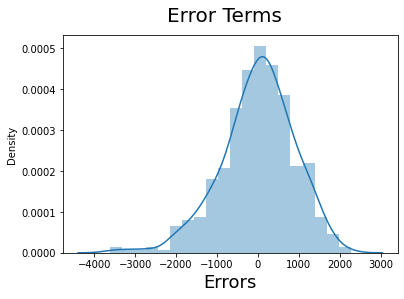

In [399]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label
plt.show()

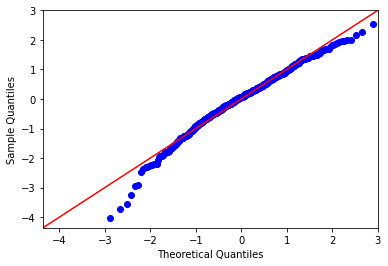

In [400]:
#Reference: https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
#           https://stats.stackexchange.com/questions/111010/interpreting-qqplot-is-there-any-rule-of-thumb-to-decide-for-non-normality/111013#111013

sm.qqplot((y_train - y_train_cnt), fit=True, line='45')
plt.show()

### **Step 9: Making prediction based on model coeff.**

###### ***Scaling Test Set***

In [401]:
num_vars=s1_test.columns.tolist()
num_vars.remove('cnt')
s1_test[num_vars] = scaler.transform(s1_test[num_vars])


In [402]:
s1_test.describe()

,yr,workingday,cnt,day,Light_air,Light_Breeze,Gentle_Breeze,Moderate_Breeze,Fresh_Breeze,Cold,...,Friday,Saturday,Much_Dry,Dry,Near_Perfect,Perfect,About_Perfect,Sweaty,Too_Humid,Gross
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.0,219.000000,...,219.000000,219.000000,219.0,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.479452,0.735160,4546.981735,0.500609,0.041096,0.333333,0.506849,0.118721,0.0,0.004566,...,0.178082,0.118721,0.0,0.009132,0.041096,0.424658,0.223744,0.178082,0.100457,0.022831
std,0.500722,0.442259,1898.633630,0.285836,0.198967,0.472484,0.501098,0.324202,0.0,0.067574,...,0.383458,0.324202,0.0,0.095344,0.198967,0.495423,0.417707,0.383458,0.301297,0.149707
min,0.000000,0.000000,441.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3303.500000,0.250000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,4579.000000,0.466667,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,5869.500000,0.766667,0.000000,1.000000,1.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,8395.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,...,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###### ***Splitting Test Data***

In [403]:
y_test = s1_test.pop('cnt')
X_test = s1_test

In [404]:
X_test.columns

Index(['yr', 'workingday', 'day', 'Light_air', 'Light_Breeze', 'Gentle_Breeze',
       'Moderate_Breeze', 'Fresh_Breeze', 'Cold', 'Quite_Cool', 'Cool',
       'Lower_Ideal', 'Ideal', 'Quite_Warm', 'Hot', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Much_Dry', 'Dry',
       'Near_Perfect', 'Perfect', 'About_Perfect', 'Sweaty', 'Too_Humid',
       'Gross'],
      dtype='object')

In [405]:
#adding constant
X_test = X_test[feature_list]
X_test = sm.add_constant(X_test)

In [406]:
##get diffirence between two lists
set(X_test.columns.tolist())-set(feature_list)
len(feature_list)

13

In [407]:
# Making predictions using model

y_pred = lr_final.predict(X_test)

### **Step 10: Model Evaluation**

```
Reference:
https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
```



Text(0, 0.5, 'y_pred')

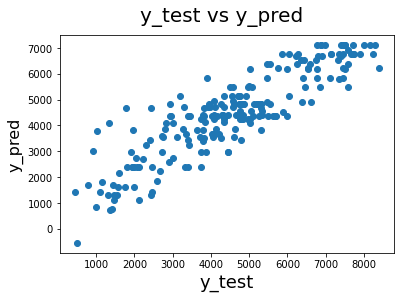

In [408]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      


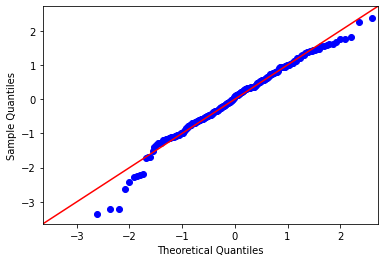

In [409]:
#Reference: https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
#           https://stats.stackexchange.com/questions/111010/interpreting-qqplot-is-there-any-rule-of-thumb-to-decide-for-non-normality/111013#111013

sm.qqplot((y_test - y_pred), fit=True, line='45')
plt.show()

Text(0.5, 0, 'Errors')

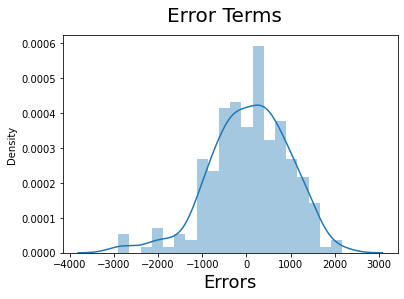

In [410]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_test - y_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)    

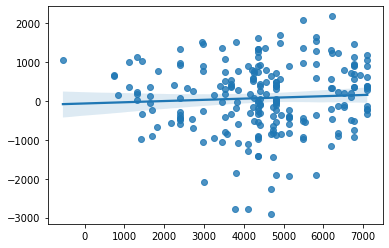

In [411]:
#plt.scatter(y_pred,(y_test - y_pred))
#plt.show()
sns.regplot(y_pred,y_test-y_pred,'r')
plt.show()

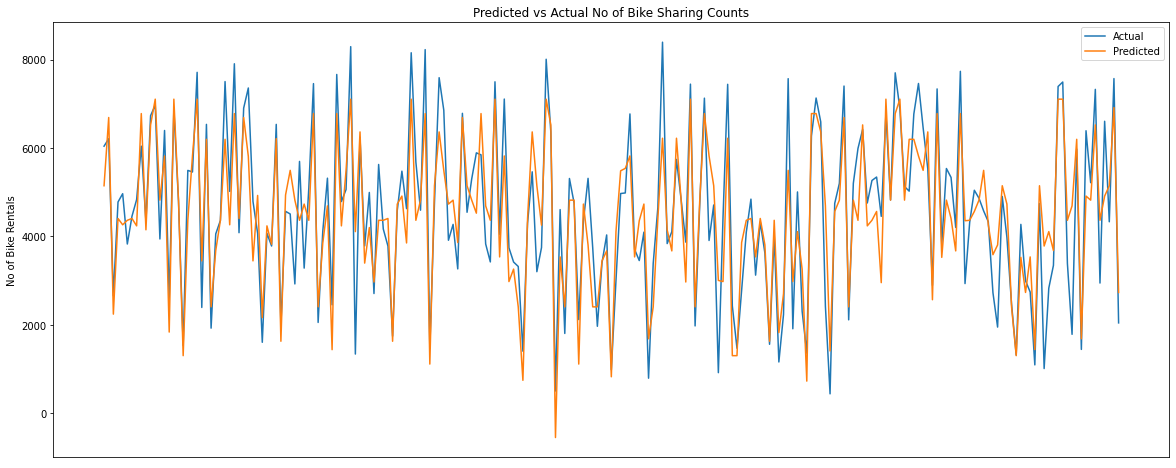

In [412]:
# Plotting Actual vs Predicted No of Shares 
fig,ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(20)
l1,=ax.plot(range(len(y_test)),y_test)
l2, = ax.plot(range(len(y_pred)),y_pred)
plt.legend([l1,l2],['Actual','Predicted'])
plt.title('Predicted vs Actual No of Bike Sharing Counts');
plt.ylabel('No of Bike Rentals')
plt.xticks([])
plt.show()


### ***Regression Metrics***

In [413]:
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
mse_train = mean_squared_error(y_train, y_train_cnt)
mae_train = mean_absolute_error(y_train, y_train_cnt)
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_train_cnt)
MAPE_test = np.mean(np.abs(y_pred - y_test) / (y_test + 1e-5))
MAPE_train = np.mean(np.abs(y_train_cnt - y_train) / (y_train + 1e-5))
print('R-squared for train data:',round(r2_train,2))
print('R-squared for test data:',round(r2_test,2))
print('Mean Squared Error for train data',round(mse_train,3))
print('Mean Absolute Error for train data',round(mae_train,3))
print('Mean Squared Error for test data',round(mse_test,3))
print('Mean Absolute Error for test data',round(mae_test,3))
print('Mean Absolute Percentage Error for test data',round(MAPE_test,3))
print('Mean Absolute Percentage Error for train data',round(MAPE_train,3))

R-squared for train data: 0.79
R-squared for test data: 0.78
Mean Squared Error for train data 806795.983
Mean Absolute Error for train data 693.157
Mean Squared Error for test data 791755.719
Mean Absolute Error for test data 705.625
Mean Absolute Percentage Error for test data 0.226
Mean Absolute Percentage Error for train data 0.547
